In [1]:
import os
import torch
from torch import nn, einsum
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
import math
from fairscale.nn.checkpoint.checkpoint_activations import checkpoint_wrapper

In [2]:
%load_ext autoreload

%autoreload

from Models.WeatherGFT import GFT
from utils.dataloader_ddp import load_data
# from utils.dataloader import load_data
from utils.losses import weighted_rmse, weighted_mae, calculate_metrics

/home/fa.buzaev/.conda/envs/my_py_env1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
from torch.cuda.amp import autocast, GradScaler

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## dataloader

In [4]:
data_root = '/home/fratnikov/weather_bench/'
prediction_horizone = 72

batch_size = 8

In [5]:
dataloader_train, dataloader_vali, dataloader_test, mean, std = load_data(batch_size=batch_size,
                                                                          val_batch_size=batch_size,
                                                                          data_root=data_root,
                                                                          num_workers=10,
                                                                          data_split='1_40625', # Разрешение и размерная сетка
                                                                          # data_split='5_625',
                                                                          data_name='mv_gft', # Название данных
                                                                          train_time=['2018', '2018'],
                                                                          # train_time=['2015', '2015'],
                                                                          # val_time=['2016', '2016'],
                                                                          # test_time=['2018', '2018'],
                                                                          val_time=None,
                                                                          test_time=None,
                                                                          idx_in=[0], # Размерность по T
                                                                          idx_out=[1, 3, 6],
                                                                          step=1,
                                                                          levels='all', fp16=True,
                                                                          distributed=False, use_augment=False,
                                                                          use_prefetcher=False, drop_last=False)

100%|██████████| 9/9 [05:26<00:00, 36.26s/it]


In [6]:
test_iterator = iter(dataloader_train)

x_test, y_test = next(test_iterator)
x_test, y_test = x_test.to(device), y_test.to(device)

In [7]:
x_test.shape, y_test.shape

(torch.Size([8, 1, 69, 128, 256]), torch.Size([8, 3, 69, 128, 256]))

In [8]:
mean = torch.Tensor(mean).unsqueeze(0)  # [1, 1, 69, 1, 1]
std = torch.Tensor(std).unsqueeze(0)    # [1, 1, 69, 1, 1]

mean = mean.to(device)
std = std.to(device)

# Денормализация
x_test = x_test * std + mean
y_test = y_test * std + mean

Эта фигня нужна была только для того, чтобы взять std и mean, с которыми модель обучалась

In [9]:
import json

with open('example_data/mean_std.json') as f:
    d = json.load(f)
    print(d)

{'mean': [278.45648193359375, -0.05302836745977402, 0.18636862933635712, 9.984565258491784e-05, 199352.578125, 157621.15625, 133121.75, 115312.953125, 101208.9609375, 89402.0234375, 69971.1171875, 54108.1796875, 40643.0625, 28925.294921875, 13748.3447265625, 7014.361328125, 738.28076171875, 212.49501037597656, 208.39463806152344, 213.29470825195312, 218.02896118164062, 222.7325439453125, 228.83114624023438, 242.09947204589844, 252.915283203125, 261.0999450683594, 267.35784912109375, 274.51837158203125, 277.3168029785156, 280.9718933105469, 6.511358737945557, 26.26487922668457, 26.794998168945312, 35.66500473022461, 47.29899978637695, 53.84512710571289, 52.585174560546875, 50.38509750366211, 51.569740295410156, 54.95396423339844, 69.12255096435547, 79.0954360961914, 78.60669708251953, 5.634260177612305, 10.268631935119629, 13.534361839294434, 14.209449768066406, 13.348237037658691, 11.804636001586914, 8.817828178405762, 6.561363220214844, 4.812414169311523, 3.3435518741607666, 1.4136286

In [10]:
for idx in range(x_test.shape[2]):
    x_test[:, :, idx] = (x_test[:, :, idx] - d['mean'][idx]) / d['std'][idx]

In [11]:
for idx in range(x_test.shape[2]):
    y_test[:, :, idx] = (y_test[:, :, idx] - d['mean'][idx]) / d['std'][idx]

In [12]:
model = GFT(hidden_dim=256,
            encoder_layers=[2, 2, 2],
            edcoder_heads=[3, 6, 6],
            encoder_scaling_factors=[0.5, 0.5, 1], # [128, 256] --> [64, 128] --> [32, 64] --> [32, 64], that is, patch size = 4 (128/32)
            encoder_dim_factors=[-1, 2, 2],

            body_layers=[4, 4, 4, 4, 4, 4], # A total of 4x6=24 HybridBlock, corresponding to 6 hours (24x15min) of time evolution
            body_heads=[8, 8, 8, 8, 8, 8],
            body_scaling_factors=[1, 1, 1, 1, 1, 1],
            body_dim_factors=[1, 1, 1, 1, 1, 1],

            decoder_layers=[2, 2, 2],
            decoder_heads=[6, 6, 3],
            decoder_scaling_factors=[1, 2, 1],
            decoder_dim_factors=[1, 0.5, 1],

            channels=69,
            head_dim=128,
            window_size=[4,8],
            relative_pos_embedding=False,
            out_kernel=[2,2],

            pde_block_depth=3, # 1 HybridBlock contains 3 PDE kernels, corresponding to 15 minutes (3x300s) of time evolution
            block_dt=300, # One PDE kernel corresponds to 300s of time evolution
            inverse_time=False).to(device)

In [13]:
if os.path.exists('checkpoints/gft.ckpt'):
    ckpt = torch.load('checkpoints/gft.ckpt', map_location=device)
    model.load_state_dict(ckpt, strict=True)
    print('[complete loading model]')

[complete loading model]


In [14]:
# Считаем количество параметров
total_params = sum(p.numel() for p in model.parameters())

print(f'Количество параметров в модели: {total_params}')

Количество параметров в модели: 470584357


In [15]:
# Извлекаем веса всех слоев
weights = []
for param in model.parameters():
    if param.requires_grad:  # Это означает, что параметр обновляется во время обучения
        weights.append(param.data.cpu().numpy())  # Переводим в numpy для удобства

# Объединяем все веса в один массив для построения гистограммы
all_weights = np.concatenate([w.flatten() for w in weights])

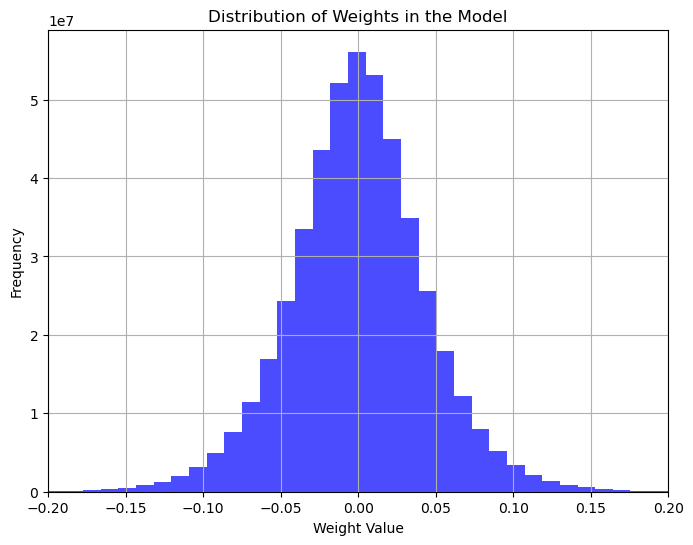

In [16]:
# Строим гистограмму
plt.figure(figsize=(8, 6))
plt.hist(all_weights, bins=1000, color='blue', alpha=0.7)
plt.title('Distribution of Weights in the Model')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-0.2, 0.2)
plt.show()

In [40]:
with torch.no_grad():
    with autocast(dtype=torch.float32):
        res = model(x_test)

In [41]:
res[0, :1, :2, :2, :2]

tensor([[[[-2.7814, -2.7817],
          [-2.8097, -2.8159]],

         [[-0.8771, -0.8638],
          [-1.1212, -1.1029]]]], device='cuda:0')

In [38]:
with torch.no_grad():
    res = model(x_test)

In [39]:
res[0, :1, :2, :2, :2]

tensor([[[[-2.7814, -2.7817],
          [-2.8097, -2.8159]],

         [[-0.8771, -0.8638],
          [-1.1212, -1.1029]]]], device='cuda:0')

In [29]:
res.shape

torch.Size([8, 3, 69, 128, 256])

In [ ]:
# outputs_full = torch.empty(x_test.shape, device=device)
outputs_full = np.empty([8, 72, 3, 69, 128, 256])
x_test_ = x_test[:, 0]
for j in range(72):
    with torch.no_grad():
        res = model(x_test_)
    outputs_full[:, j] = res.cpu().detach().numpy()
    x_test_ = res[:, 0]

In [ ]:
outputs_every_3 = np.empty([8, 72, 3, 69, 128, 256])  # размерность подгоните под задачу
x_test_ = x_test[:, 0]

for j in range(72):
    with torch.no_grad():
        
        res = model(x_test_)
        if j == 0:
            res_3 = res[:, 1]
            
        # Если j+1 кратно 3, обновляем x_test_ предсказанием с нулевого шага
        if (j + 1) % 3 == 0:
            x_test_ = res_3
            res_3 = res[:, 1]
        else:
            # Иначе продолжаем предсказывать на основе последнего результата
            x_test_ = res[:, 0]
        
    # Сохраняем предсказание для текущего шага
    outputs_every_3[:, j] = res.cpu().detach().numpy()

In [ ]:
outputs_every_6 = np.empty([8, 72, 3, 69, 128, 256])  # размерность подгоните под задачу
x_test_ = x_test[:, 0]

for j in range(72):
    with torch.no_grad():
        res = model(x_test_)
        
        if j == 0:
            res_3 = res[:, 1]
            res_6 = res[:, 2]  # сохраняем предсказание для шестого часа
    
    # Сохраняем предсказание для текущего шага
    outputs_every_6[:, j] = res.cpu().detach().numpy()
    
    # Обновляем x_test_ в зависимости от текущего часа
    if (j + 1) % 6 == 0:        # Каждые 6 часов
        x_test_ = res_6
        res_6 = res[:, 2]
    elif (j + 1) % 3 == 0:       # Каждые 3 часа (если не кратно 6)
        x_test_ = res_3
        res_3 = res[:, 1]
    else:                        # Остальные часы
        x_test_ = res[:, 0]

In [ ]:
outputs_every_6_2 = np.empty([8, 72, 3, 69, 128, 256], dtype=np.half)  # размерность подгоните под задачу
x_test_ = x_test[:, 0]

for j in range(72):
    with torch.no_grad():
        res = model(x_test_)
        
        if j == 0:
            res_6 = res[:, 2]  # сохраняем предсказание для шестого часа
    
    # Сохраняем предсказание для текущего шага
    outputs_every_6_2[:, j] = res.cpu().detach().numpy()
    
    # Обновляем x_test_ в зависимости от текущего часа
    if (j + 1) % 6 == 0:        # Каждые 6 часов
        x_test_ = res_6
        res_6 = res[:, 2]
    else:                        # Остальные часы
        x_test_ = res[:, 0]

In [29]:
def denorm(item, std, mean, idx=0):
    mean = mean[idx]
    std = std[idx]
    item_denorm = item * std + mean
    return item_denorm